In [221]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles,readMergedProfiles2
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### In this notebook we test how combinting two data modalities will improve preformance of the following tasks:
    1 - MOA prediction
    2 - ?

## MOA Prediction:
- Methods:
    - Baseline: simple concatenation
    - SNF
    - prbabilistic modeling

In [2]:
# list(set(mergProf_treatLevel.columns.tolist())-set(l1k_features))
import os
os.listdir('./preprocessed_data/LINCS-Pilot1/CellPainting/')

['replicate_level_cp_normalized_dmso.csv.gz',
 'replicate_level_cp_augmented.csv.gz',
 'replicate_level_cp_normalized_feature_select_dmso.csv.gz',
 'replicate_level_cp_normalized_feature_select.csv.gz',
 'replicate_level_cp_normalized.csv.gz']

## Treatment level

In [384]:
dataset_rootDir='./';pertColName='PERT'
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS','CDRP-bio'
dataset='CDRP';

# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
# lincs --> normalized_feature_select_dmso
profileType='normalized'
profileLevel='treatment'; #'replicate'  or  'treatment'
highRepOverlapEnabled=0

# n of samples for replicate picking options: numbers or, 'max'
nRep=1
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(dataset_rootDir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);
# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))]
    cp=mergProf_treatLevel[list(set(mergProf_treatLevel.columns.tolist())-set(l1k_features))]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           



# moa_col='moa'
moa_col='Metadata_moa'
if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()
#     merged_scaled=pd.merge(cp, l1k, how='inner',on=['PERT',moa_col]);

# ###    l1k[moa_col]=cp[moa_col] # for CDRP
####     merged_scaled=pd.merge(cp, l1k, how='inner',on=['PERT',moa_col]); # for CDRP
    merged_scaled=pd.concat([cp, l1k], axis=1)
    merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1800,1801,1802,1803) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


CDRP: Replicate Level Shapes (nSamples x nFeatures): cp:  153386 , 1565 ,  l1k:  68120 , 977
l1k n of rep:  3.0
cp n of rep:  4.0
Treatment Level Shapes (nSamples x nFeatures+metadata): (30620, 1568) (21850, 981) Merged Profiles Shape: (20131, 2548)


In [350]:
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]

In [342]:
# just_comp_treatLevel=mergProf_treatLevel[mergProf_treatLevel['PERT']=='DMSO']
# mergProf_treatLevel[mergProf_treatLevel['PERT']=='DMSO'].shape
l1k.shape,cp.shape

((20131, 984), (20131, 1572))

In [239]:
mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()].shape

(592, 1584)

In [236]:
mergProf_treatLevel.shape

(1919, 1584)

In [330]:
mergProf_treatLevel[~mergProf_treatLevel['Metadata_moa'].isnull()].shape[0]/mergProf_treatLevel.shape[0]

0.6915059927045336

In [234]:
mergProf_treatLevel.shape

(1919, 1584)

In [574]:
# LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 1670 ,  l1k:  27837 , 978
# l1k n of rep:  3.0
# cp n of rep:  5.0
# CP: from  9394  to  4647
# l1k: from  8369  to  2338
# CP and l1k high rep overlap:  1140
# Treatment Level Shapes (nSamples x nFeatures+metadata): (1141, 1671) (1141, 979) Merged Profiles Shape: (1141, 2649)


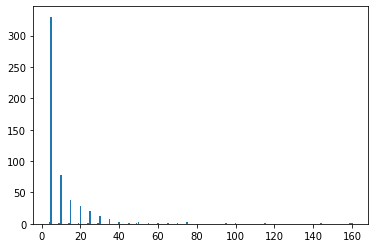

In [34]:
repp_df=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'nrep'}).groupby(['nrep']).size().reset_index()
plt.bar(repp_df['nrep'].values, repp_df[0].values);

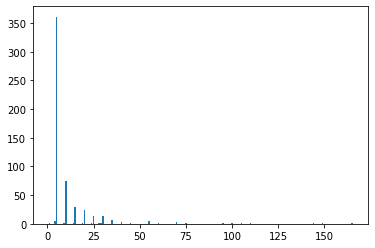

In [133]:
repp_df=mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).groupby(['nrep']).size().reset_index()
plt.bar(repp_df['nrep'].values, repp_df[0].values);

In [139]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
moa_col='moa'

In [292]:
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

191


In [225]:
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

14


In [226]:
listOfSelectedMoAs

['ATPase inhibitor',
 'tubulin polymerization inhibitor',
 'CDK inhibitor',
 'retinoid receptor agonist',
 'calcium channel blocker',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'mitochondrial oxidative phosphorylation uncoupler',
 'HDAC inhibitor|cell cycle inhibitor',
 'HDAC inhibitor',
 'protein tyrosine kinase inhibitor|tyrosine kinase inhibitor',
 'EGFR inhibitor',
 'p38 MAPK inhibitor',
 'topoisomerase inhibitor']

In [144]:
# mergProf_treatLevel['moa'].str.lower().unique().shape

In [143]:
# mergProf_treatLevel['moa'].unique().shape

In [36]:
# mergProf_treatLevel.Metadata_moa.unique().shape
nSamplesforEachMOAclass

,Metadata_moa,size
0,adrenergic receptor antagonist,160
1,phosphodiesterase inhibitor,159
2,cyclooxygenase inhibitor,144
3,histamine receptor antagonist,115
4,acetylcholine receptor antagonist,100
...,...,...
547,dna directed dna polymerase inhibitor|dna synt...,5
548,glucagon receptor antagonist,5
549,leukotriene receptor antagonist|lipoxygenase i...,4
550,flt3 inhibitor|kit inhibitor|pdgfr tyrosine ki...,4


In [271]:
merged_scaled.columns[merged_scaled.columns.str.contains('moa')]

Index(['Metadata_moa'], dtype='object')

In [130]:
merged_scaled[['Metadata_alternative_moa_x', 'Metadata_moa_x', 'moa_x', 'moa_y',
       'Metadata_moa_y', 'Metadata_alternative_moa_y']]

,Metadata_alternative_moa_x,Metadata_moa_x,moa_x,moa_y,Metadata_moa_y,Metadata_alternative_moa_y
0,NaN,insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist,NaN
1,NaN,insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist,NaN
2,NaN,insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist,NaN
3,NaN,insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist,NaN
4,NaN,insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist,NaN
...,...,...,...,...,...,...
6980,NaN,NaN,Potassium channel activator,Potassium channel activator,NaN,NaN
6981,NaN,NaN,Potassium channel activator,Potassium channel activator,NaN,NaN
6982,NaN,NaN,Potassium channel activator,Potassium channel activator,NaN,NaN
6983,NaN,NaN,Potassium channel activator,Potassium channel activator,NaN,NaN


In [323]:
xxx=mergProf_treatLevel.groupby(['Compounds']).size().reset_index()
# xxx[xxx[0]==2]
# xxx[xxx[0]==2]
xxx

,Compounds,0
0,BRD-A00100033,1
1,BRD-A00267231,1
2,BRD-A00520476,1
3,BRD-A00993607,1
4,BRD-A01078468,1
...,...,...
1320,BRD-K78122587,1
1321,BRD-K78280988,1
1322,BRD-K90382497,1
1323,BRD-K92723993,1


In [321]:
nSamplesforEachMOAclass

,Metadata_moa,size
0,Adrenergic receptor antagonist,32
1,Cyclooxygenase inhibitor,26
2,Dopamine receptor antagonist,22
3,Acetylcholine receptor antagonist,19
4,dopamine receptor antagonist,18
...,...,...
609,Protein kinase inhibitor,1
610,Proteasome inhibitor,1
611,Progestogen hormone,1
612,Progesterone receptor agonist,1


In [320]:
# mergProf_treatLevel[mergProf_treatLevel['Compounds']=='BRD-K73323637'].Metadata_moa
nSamplesforEachMOAclass2

,Metadata_moa,size
0,Adrenergic receptor antagonist,32
1,Cyclooxygenase inhibitor,26
2,Dopamine receptor antagonist,22
3,Acetylcholine receptor antagonist,19
4,dopamine receptor antagonist,18
...,...,...
609,Proteasome inhibitor,1
610,Progestogen hormone,1
611,Progesterone receptor agonist,1
612,Platelet aggregation inhibitor,1


### Single Modalities Classification performance

In [399]:
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# nSamplesMOA=10 # results in grant for CDRP are for this number of MOAs
nSamplesMOA=5
# from MulticoreTSNE import MulticoreTSNE as TSNE
# df_1 = df_1.interpolate()
#############

##########
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel[moa_col].isnull()].reset_index(drop=True)
mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]


nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
# lkjklj
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].tolist()


cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]

data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

# for r in range(len(data4eval)): #range(1):#
#     print(r)
#     domXdata=data4eval[r][0];
#     domXfeats=data4eval[r][1]
#     domXfeats['Metadata_moa_num']=le.transform(domXfeats['Metadata_moa'].tolist())
    
#     filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)

#     data = filteredMOAs[domXfeats].values;
#     labels=filteredMOAs.Metadata_moa.tolist()
        
#     loocv = LeaveOneOut()
#     model_loocv = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000)
#     results_loocv = cross_val_score(model_loocv, data, labels, cv=loocv)
#     print("Accuracy: %.2f%%" % (results_loocv.mean()*100.0))

In [378]:
# cp.shape,l1k.shape,merged_scaled.shape
# merged_scaled['PERT']
# mergProf_treatLevel[moa_col].unique()
# mergProf_treatLevel
# IDs4filteredMOAs
mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)]['Compounds'].shape

(601,)

In [376]:
len(listOfSelectedMoAs),len(IDs4filteredMOAs),mergProf_treatLevel.shape

(72, 601, (997, 1102))

In [257]:
# merged_scaled['PERT']
# listOfSelectedMoAs
# cp_features
pertColName

'PERT'

In [246]:
# import os
# os.mkdir('../../results/dataIntegration')

In [228]:
len(listOfSelectedMoAs) #filt set (n>1) CDRP

14

In [296]:
len(listOfSelectedMoAs) #full set (n>1) cdrp

191

In [533]:
len(listOfSelectedMoAs) #full set (n>3)

84

In [547]:
len(listOfSelectedMoAs) #filt set(n>3)

24

In [96]:
len(listOfSelectedMoAs) #filt set (n>1)

72

In [366]:
len(listOfSelectedMoAs) #full set (n>1)

191

In [437]:
cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]

data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [245]:
ls ../../results/

checkpoint                 GeneVsCPfeature/
cpCategoriesHM-LINCS.png   modelW/
cpCategoriesHM.png         modelW.data-00000-of-00001
cpFeaturesGene_ccMat.csv   modelW.index
cpFeaturesGene_ccMat.eps   RepCor/
cpFeaturesGene_ccMat.pkl   results.csv
cpFeaturesGene_ccMat.png   results-nnC.csv
cpFeaturesGene_glmMat.csv  results-replicate-nnC.csv
cpFeaturesGene_glmMat.pkl  results-Treatment12120end.csv
cpFeaturesGene_glmMat.png  results-Treatment_1t0121.csv
cpFeaturesGene_miMat.csv   results-Treatment.csv
cpFeaturesGene_miMat.pkl   results-Treatment-lin-rand.csv
cpFeaturesGene_miMat.png   SingleCPfeatPred/
dataIntegration/           SingleGenePred/


In [247]:
# DataFuseResults
# pd.to_csv('../../results/dataIntegration/fusion_res.xlsx')
res_path='../../results/dataIntegration/fusion_res.xlsx'
saveAsNewSheetToExistingFile(res_path,DataFuseResults,'logisticReg')

In [363]:
saveAsNewSheetToExistingFile(res_path,DataFuseResults_loaded,'logisticReg')

[]


In [366]:
# DataFuseResults_loaded=pd.read_excel(res_path, sheet_name=None)['logisticReg']
# DataFuseResults_loaded

In [195]:
DataFuseResults=pd.DataFrame(columns=["Data","Modality"])
i=0
for d in ['Filtered','All']:
    for m in ['CP','GE','CP+GE']:
        temp_df=pd.DataFrame(data=Acc_all2[i],columns=['acc'])
        temp_df['Modality']=m
        temp_df['Data']=d        
        i+=1
        DataFuseResults=DataFuseResults.append(temp_df)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


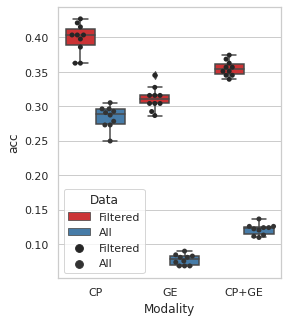

In [219]:
plt.figure(figsize=(4,5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Modality", y="acc", hue="Data",data=DataFuseResults, palette="Set1")
ax = sns.swarmplot(x="Modality", y="acc", hue="Data",data=DataFuseResults,dodge=True,color=".2")

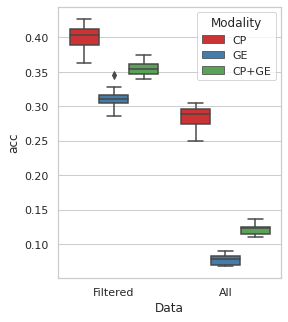

In [220]:
plt.figure(figsize=(4,5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="acc", hue="Modality",data=DataFuseResults, palette="Set1")
# ax = sns.swarmplot(x="Modality", y="acc", hue="Data",data=DataFuseResults,dodge=True,color=".2")

In [373]:
# DataFuseResults_loaded['NMI']=DataFuseResults_loaded['NMI']*100
DataFuseResults

,Unnamed: 0,Unnamed: 0.1,Data,Modality,acc,NMI
0,0,0.0,Filtered,CP,40.350877,NaN
1,1,1.0,Filtered,CP,40.350877,NaN
2,2,2.0,Filtered,CP,40.350877,NaN
3,3,3.0,Filtered,CP,38.596491,NaN
4,4,4.0,Filtered,CP,36.257310,NaN
...,...,...,...,...,...,...
115,115,NaN,All-snf,GE,NaN,54.545382
116,116,NaN,All-snf,"fused(CP,GE)",NaN,67.028042
117,117,NaN,All-snf,CP,NaN,40.139434
118,118,NaN,All-snf,GE,NaN,41.827826


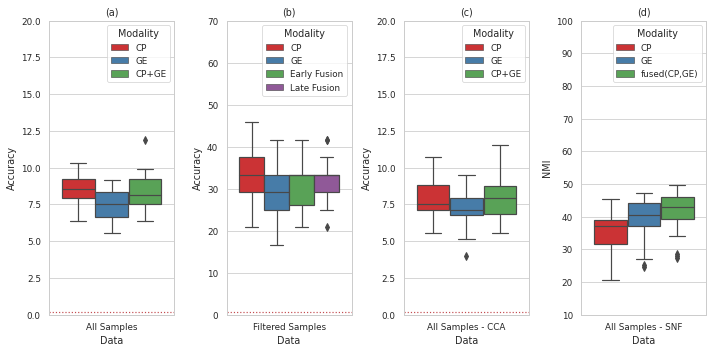

In [655]:
# DataFuseResults=DataFuseResults_loaded.copy()
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

fig, axes = plt.subplots(1,4,figsize=(10,5))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            palette="Set1",ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,20)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            palette="Set1",ax=axes[1])
axes[1].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[1].set_ylim(0,70)
axes[1].set_title('(b)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            hue_order=['CP','GE','CP+GE'],palette="Set1",ax=axes[2])
axes[2].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[2].set_ylim(0,20)
axes[2].set_title('(c)');

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="Set1",ax=axes[3])
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[3].set_ylim(10,100)
axes[3].set_title('(d)');
fig.tight_layout()
#         sns.distplot(pred_scoress,kde=True,hist=True,bins=100,label=datasets[d],ax=axes[d,m],norm_hist=True,color='r')
#         sns.distplot(rand_scoress,kde=True,hist=True,bins=100,label='random',ax=axes[d,m],norm_hist=True)
#         print(np.percentile(rand_scoress,90))
#         axes[d,m].set_xlim(-1,1)
#         axes[d,m].set_xlim(-0.5,0.6)
# #         axes[d,m].set_ylim(0,15)
#         axes[d,m].axvline(x=np.percentile(rand_scoress,90),linestyle=':',color='r');
#         axes[len(datasets)-1,m].set_xlabel("Accuracy ($R^2$)");
#         axes[d,m].legend();
#         axes[0,m].set_title(models[m]);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


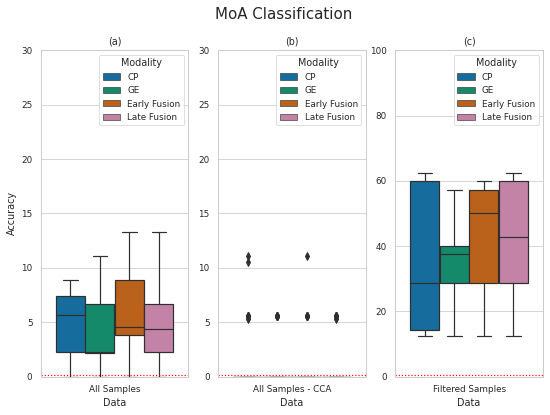

In [409]:
import matplotlib.style as style
style.use('seaborn-colorblind')
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

hfont = {'fontname':'sans-serif'}

# plt.title('title',**csfont)

fig, axes = plt.subplots(1,3,figsize=(9,6))
fig.suptitle('MoA Classification', fontsize=15,**hfont)

sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,30)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            ax=axes[2])
axes[2].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[2].set_ylim(0,100)
axes[2].set_title('(c)');
axes[2].set(ylabel=None)

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            ax=axes[1])
# hue_order=['CP','GE','CP+GE']
axes[1].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[1].set_ylim(0,30)
axes[1].set_title('(b)');
axes[1].set(ylabel=None)

# sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
#             palette="cividis",ax=axes[3])
# # axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
# axes[3].set_ylim(0,100)
# axes[3].set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clussif.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


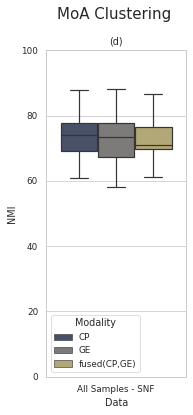

In [410]:
fig, axes = plt.subplots(1,1,figsize=(2.5,6))
fig.suptitle('MoA Clustering', fontsize=15,**hfont)

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="cividis",ax=axes)
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes.set_ylim(0,100)
axes.set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clustering.eps',bbox_inches='tight')

In [353]:
# DataFuseResults_loaded
DataFuseResults_loaded=DataFuseResults_loaded.append(ress_df,ignore_index=True)

In [408]:
# listOfSelectedMoAs
# list(le.classes_)
# train_index.shape,filteredMOAs.shape
# test_index
# Acc_all
# DataFuseResults[DataFuseResults['Data']=='All']

# DataFuseResults

# temp_df

DataFuseResults=pd.DataFrame(columns=["Data","Modality"])

# DataFuseResults_loaded['acc']=DataFuseResults_loaded['acc']*100
# i=0
for d in ['All Samples - CCA']:
# for d in ['All Samples - CCA']:
    for n,m in zip([0,1,2,3],['CP','GE','Early Fusion','Late Fusion']):
        temp_df=pd.DataFrame(data=acc_array_cca_full2_cdrp[:,n],columns=['acc'])
        temp_df['Modality']=m
        temp_df['Data']=d        
#         i+=1
        DataFuseResults=DataFuseResults.append(temp_df,ignore_index=True)

# for d in ['Filt Samples - CCA']:
#     for n,m in zip([0,1,2,3],['CP','GE','Early Fusion','Late Fusion']):
#         temp_df=pd.DataFrame(data=acc_array_filt2[:,n],columns=['acc'])
#         temp_df['Modality']=m
#         temp_df['Data']=d        
# #         i+=1
#         DataFuseResults=DataFuseResults.append(temp_df,ignore_index=True)

for d in ['All Samples']:
    for n,m in zip([0,1,2,3],['CP','GE','Early Fusion','Late Fusion']):
        temp_df=pd.DataFrame(data=acc_array_fullSet2_cdrp[:,n],columns=['acc'])
        temp_df['Modality']=m
        temp_df['Data']=d        
#         i+=1
        DataFuseResults=DataFuseResults.append(temp_df,ignore_index=True)
    
    
for d in ['Filtered Samples']:
    for n,m in zip([0,1,2,3],['CP','GE','Early Fusion','Late Fusion']):
        temp_df=pd.DataFrame(data=acc_array_filtSet2_cdrp[:,n],columns=['acc'])
        temp_df['Modality']=m
        temp_df['Data']=d        
#         i+=1
        DataFuseResults=DataFuseResults.append(temp_df,ignore_index=True)

# ress_df['Data']='All Samples - SNF'
# ress_df_filt['Data']='All Samples - SNF'

ress_df_full_cdrp['Data']='All Samples - SNF'
# ress_df_full_cdrp
DataFuseResults=DataFuseResults.append(ress_df_full_cdrp,ignore_index=True)
DataFuseResults['NMI']=DataFuseResults['NMI']*100

In [530]:
# acc_array_fullSet=np.copy(acc_array_filtSet)

In [394]:
DataFuseResults_lincs=DataFuseResults.copy()

In [39]:
# test_index
# filteredMOAs
# len(data4eval)
# xx=filteredMOAs.groupby(['Metadata_moa_num']).sample(1)
# xx
filteredMOAs

In [258]:
# # xx.sample(20)
# # filteredMOAs['Compounds'].unique().shape
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=n_of_random_sel,random_state=2,shuffle=True)

# # KFold(n_splits=2, random_state=None, shuffle=False)
# for train_index, test_index in kf.split(filteredMOAs):
#     print(test_index)
# len(train_index)
# filteredMOAs[moa_col].unique()
# filteredMOAs['Metadata_moa_num'].unique()

In [336]:
# filteredMOAs.groupby([moa_col]).size().describe()
filteredMOAs.shape

(906, 2554)

In [353]:
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

Acc_list=[]

# n_of_random_sel=20
# n_of_random_sel=50
n_of_random_sel=20
acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
# acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):

kf = KFold(n_splits=n_of_random_sel,random_state=1,shuffle=True)
i=0
for train_index0, test_index in kf.split(filteredMOAs):
    print('rand ',i)
# for outdim_size in range(10,110,10):
#     test_index=filteredMOAs.groupby(['Metadata_moa_num']).sample(1).sample(50).index.values
#     hgfhf
    unq_comp_test=filteredMOAs.loc[test_index,'Compounds'].unique().tolist()
    
#     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().tolist())
#     print(len(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().tolist()))
    
    testFiltMoA=filteredMOAs.loc[test_index,:]
    
    
    comp_to_remove_from_train=filteredMOAs[filteredMOAs['Compounds'].isin(unq_comp_test)].index.values
#         print(test_index[0:30])
#         khhk
    train_index=np.array(list(set(filteredMOAs.index.values)-set(test_index)-set(comp_to_remove_from_train)))

    train_moaClassess=filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().tolist()
    test_moaClassess=filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().tolist()   


#     if len(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().tolist())=70:
#         sfsdssf
    test_cl_toRemove=list(set(test_moaClassess)-set(train_moaClassess))
    test_ind_toRemo=testFiltMoA[testFiltMoA['Metadata_moa_num'].isin(test_cl_toRemove)].index

    print(test_cl_toRemove,test_ind_toRemo)
    test_index=np.array(list(set(test_index)-set(test_ind_toRemo)))
    
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()

#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    probs=[]
    for n,dt_modality in zip([0,1,2],data4eval):
        
        data_m=dt_modality[0][dt_modality[0][pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)        

        dt_train=data_m.loc[train_index,dt_modality[1]].values;
        dt_test=data_m.loc[test_index,dt_modality[1]].values; 
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr = GaussianNB()
#         model_tr = ComplementNB()

        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=1,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
        accc=model_tr.score(dt_test,labels_test)
        probs.append(model_tr.predict_proba(dt_test))
        model_tr.classes_
#         print(accc)
        acc_array_fullSet2_cdrp[i,n]=accc*100
#         acc_array_filtSet2_cdrp[i,n]=accc*100
        
        Acc_list.append(accc);
    
#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
    acc_array_fullSet2_cdrp[i,n+1]=accuracy_score(labels_test,labels_lateFusion)*100
#     acc_array_filtSet2_cdrp[i,n+1]=accuracy_score(labels_test,labels_lateFusion)*100
    i+=1
    
#     hfh
print(np.median(acc_array_fullSet2_cdrp,axis=0))
# print('Accuracy: ',r, np.mean(Acc_list)*100)  

rand  0
[] Int64Index([], dtype='int64')
rand  1
[] Int64Index([], dtype='int64')
rand  2
[] Int64Index([], dtype='int64')
rand  3
[] Int64Index([], dtype='int64')
rand  4
[] Int64Index([], dtype='int64')
rand  5
[] Int64Index([], dtype='int64')
rand  6
[] Int64Index([], dtype='int64')
rand  7
[] Int64Index([], dtype='int64')
rand  8
[] Int64Index([], dtype='int64')
rand  9
[] Int64Index([], dtype='int64')
rand  10
[] Int64Index([], dtype='int64')
rand  11
[58] Int64Index([225, 698], dtype='int64')
rand  12
[] Int64Index([], dtype='int64')
rand  13
[] Int64Index([], dtype='int64')
rand  14
[] Int64Index([], dtype='int64')
rand  15
[] Int64Index([], dtype='int64')
rand  16
[127] Int64Index([338, 470], dtype='int64')
rand  17
[156] Int64Index([190, 775], dtype='int64')
rand  18
[27] Int64Index([466, 595], dtype='int64')
rand  19
[] Int64Index([], dtype='int64')


NameError: name 'acc_array_fultSet2_cdrp' is not defined

In [354]:
# train_index
# data_m
# len(dt_modality[1])
print(np.median(acc_array_fullSet2_cdrp,axis=0))

[5.65891473 2.27390181 4.54780362 4.39613527]


In [162]:
# acc_array_fullSet2

# list(set(test_moaClassess)-set(train_moaClassess)
# model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
np.median(acc_array_filtSet2,axis=0)

array([38.33333333, 39.64285714, 43.33333333, 43.33333333])

In [160]:
np.argmax((probs[0]+probs[1])/2,axis=1)

array([18, 56, 41, 31, 39, 20, 36, 69, 36, 56, 26, 54, 15, 13, 26, 36, 22,
       71, 14, 64, 61, 15, 35, 69, 11, 59, 35, 15, 17, 69])

In [157]:
model_tr.predict(dt_test)

array([18, 69, 41, 31, 39, 20, 36, 69, 36, 56, 26, 54, 13, 13, 26, 36, 51,
       64, 14, 64, 61, 15, 35, 61, 11, 59, 35, 15, 17, 69])

In [158]:
np.argmax((probs[0]+probs[1])/2,axis=1)

array([18, 56, 41, 31, 39, 20, 36, 69, 36, 56, 26, 54, 15, 13, 26, 36, 22,
       71, 14, 64, 61, 15, 35, 69, 11, 59, 35, 15, 17, 69])

In [129]:
# accuracy_score(labels_test,labels_lateFusion)
# len(labels_lateFusion),len(labels_test)
# labels_lateFusion
np.median(acc_array_filtSet2,axis=0)

array([38.33333333, 38.33333333, 43.33333333, 43.33333333])

In [87]:
np.median(acc_array_fullSet,axis=0)

array([7.17488789, 6.7264574 , 7.17488789, 0.89686099])

In [89]:
np.median(acc_array_fullSet2,axis=0)

array([7.82147316, 6.74157303, 7.86516854, 6.74157303])

In [628]:
# np.argmax(model_tr.predict_proba(dt_train),axis=1)
# labels_lateFusion=np.argmax((probs[0]+probs[1])/2,axis=1)
# accc
accuracy_score(model_tr.predict(dt_test),labels_test)

0.375

In [631]:
# model_tr.predict(dt_train)
accuracy_score(labels_test,labels_test)

1.0

In [471]:
# dt_modality[0]
len(labels_test),dt_test.shape,accc

(191, (191, 119), 0.005235602094240838)

In [489]:
# model_tr.predict(dt_test)
# train_index
test_index

array([2004, 4042, 3343, 3729,  740, 3956,  640, 1293,  881, 4058, 3827,
       1135, 3461, 3125,  526,  105, 2891,  718, 1181, 2900,  115, 1730,
       2680, 3643, 4017, 3486,  812, 3866,  124, 3033,  992, 3108, 2619,
       1929, 2461, 3372,  269, 4224, 2399, 1392, 1574, 1033,   75,  425,
       2442, 3346, 2198, 2413,  282, 1939, 1122,  404, 3788,  651,  553,
        735,  797, 4016, 1685, 1748, 1640, 1368, 4036, 4280, 3710, 2595,
       3702, 3605, 2108, 2146, 2631,  274,   47, 4197, 1972, 3146, 2985,
       4426,  933, 3563,  981, 2101,  310, 3903,  590, 3053, 3025, 1853,
       2334, 1871, 4421, 1126, 3418, 1544, 1312, 2128, 3883, 1825, 2756,
        770, 2022,  505, 2837, 2445, 3772, 2923, 1681, 3044, 3598, 2993,
        936, 1283,  862, 2855, 2724, 2477, 2567, 1068, 2528,   80, 4270,
          9,  375, 1866, 1334, 1892, 1219,  968, 3264, 1398, 4215, 2949,
       1708, 4232, 4437, 2663, 3380, 3857, 4152,  978,  577, 3218, 1945,
       2395,  569,  748, 3636, 1584, 1489, 1805, 16

In [480]:
Acc_all=[]
Acc_all2=[]

n_of_random_sel=10
acc_array_fullSet=np.zeros((n_of_random_sel,3));        

from sklearn.utils import class_weight
for r in range(len(data4eval)): #range(1):#
    print(r)
    domXdata=data4eval[r][0];
    domXfeats=data4eval[r][1]
    
    
    filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
    filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())
#     filteredMOAs['Compounds']=filteredMOAs['PERT'].str[0:13]
    
    Acc_list=[]
    for i in range(n_of_random_sel):
        test_index=filteredMOAs.groupby(['Metadata_moa_num']).sample(1).index.values
        
        unq_comp_test=filteredMOAs.loc[test_index,'Compounds'].unique().tolist()
        comp_to_remove_from_train=filteredMOAs[filteredMOAs['Compounds'].isin(unq_comp_test)].index.values
#         print(test_index[0:30])
#         khhk
        train_index=np.array(list(set(filteredMOAs.index.values)-set(test_index)-set(comp_to_remove_from_train)))

        data_train = filteredMOAs.loc[train_index,domXfeats].values;
        labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
        
        data_test = filteredMOAs.loc[test_index,domXfeats].values;
        labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
        
        class_weightt = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=100,max_iter=1000,class_weight=class_weightt)
        model_tr.fit(data_train,labels_train)
        accc=model_tr.score(data_test,labels_test)
        print(accc)        
        Acc_list.append(accc)
        acc_array_fullSet[i,n]=accc*100
        khjlhglg
    print(Acc_list)
    print('Accuracy: ',r, np.mean(Acc_list)*100)   
    
    Acc_all2.append(Acc_list)
    Acc_all.append(np.mean(Acc_list)*100)
#     loocv = LeaveOneOut()
#     model_loocv = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000)
#     results_loocv = cross_val_score(model_loocv, data, labels, cv=loocv)
#     print("Accuracy: %.2f%%" % (results_loocv.mean()*100.0))

0


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190], y=[172, 172, 172, 172, 172, 8, 8, 8, 8, 8, 117, 117, 117, 117, 117, 169, 169, 169, 169, 169, 15, 15, 15, 15, 15,

0.07329842931937172


NameError: name 'khjlhglg' is not defined

In [482]:
domXfeats

['Cytoplasm_Correlation_RWC_ER_RNA',
 'Nuclei_Granularity_2_ER',
 'Nuclei_Texture_InfoMeas1_DNA_20_0',
 'Nuclei_Texture_InfoMeas1_RNA_20_0',
 'Nuclei_Texture_InfoMeas2_DNA_20_0',
 'Cytoplasm_Granularity_5_RNA',
 'Nuclei_RadialDistribution_RadialCV_RNA_2of4',
 'Cytoplasm_Correlation_Correlation_ER_AGP',
 'Cells_Correlation_Overlap_Mito_AGP',
 'Nuclei_AreaShape_Zernike_8_2',
 'Cells_AreaShape_Zernike_8_4',
 'Cytoplasm_AreaShape_Zernike_9_1',
 'Cytoplasm_AreaShape_Zernike_9_3',
 'Cytoplasm_Texture_InfoMeas1_AGP_20_0',
 'Nuclei_AreaShape_Zernike_6_0',
 'Cytoplasm_Correlation_K_DNA_AGP',
 'Cells_AreaShape_Zernike_6_0',
 'Cytoplasm_Correlation_Overlap_ER_AGP',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_4of4',
 'Cytoplasm_Granularity_6_ER',
 'Nuclei_RadialDistribution_RadialCV_AGP_4of4',
 'Cytoplasm_AreaShape_Zernike_4_2',
 'Nuclei_AreaShape_Zernike_3_1',
 'Cytoplasm_RadialDistribution_MeanFrac_ER_3of4',
 'Nuclei_Granularity_7_DNA',
 'Nuclei_Correlation_Correlation_Mito_ER',
 'Cytoplasm_Text

In [446]:
Acc_all2

[[0.06282722513089005,
  0.06806282722513089,
  0.05759162303664921,
  0.03664921465968586,
  0.05235602094240838,
  0.06282722513089005,
  0.041884816753926704,
  0.03664921465968586,
  0.04712041884816754,
  0.07329842931937172],
 [0.05235602094240838,
  0.05235602094240838,
  0.03664921465968586,
  0.041884816753926704,
  0.05235602094240838,
  0.03664921465968586,
  0.041884816753926704,
  0.05235602094240838,
  0.05759162303664921,
  0.04712041884816754],
 [0.05759162303664921,
  0.07329842931937172,
  0.05759162303664921,
  0.08376963350785341,
  0.05235602094240838,
  0.06806282722513089,
  0.05759162303664921,
  0.06806282722513089,
  0.05235602094240838,
  0.07853403141361257]]

In [171]:
Acc_all3=Acc_all2.copy()
Acc_all3

[[0.27898550724637683,
  0.29528985507246375,
  0.30434782608695654,
  0.28804347826086957,
  0.26268115942028986,
  0.2753623188405797,
  0.2554347826086957,
  0.27717391304347827,
  0.25181159420289856,
  0.266304347826087],
 [0.07608695652173914,
  0.07971014492753623,
  0.09420289855072464,
  0.1068840579710145,
  0.09963768115942029,
  0.07789855072463768,
  0.08514492753623189,
  0.10507246376811594,
  0.07971014492753623,
  0.09239130434782608],
 [0.12387791741472172,
  0.12746858168761221,
  0.13285457809694792,
  0.10771992818671454],
 [0.09156193895870736,
  0.08797127468581688,
  0.09694793536804308,
  0.09694793536804308],
 [0.18850987432675045,
  0.17773788150807898,
  0.17055655296229802,
  0.15080789946140036],
 [0.38011695906432746,
  0.4093567251461988,
  0.3391812865497076,
  0.40350877192982454],
 [0.2807017543859649,
  0.34502923976608185,
  0.3157894736842105,
  0.3333333333333333],
 [0.32748538011695905,
  0.36257309941520466,
  0.391812865497076,
  0.350877192982

In [ ]:
2
[0.09156193895870736, 0.08797127468581688, 0.09694793536804308, 0.09694793536804308]
Accuracy:  2 9.33572710951526

In [90]:
# domXfeats['Metadata_moa']
# domXdata['Metadata_moa'].tolist()
model_tr.predict(data_test)
# Acc_list

array([379, 379, 379, ...,  24,  24,  24])

In [158]:
class_weightt.shape

(557,)

In [152]:
import multiprocessing

multiprocessing.cpu_count()

16

In [149]:
Acc_all2

[[0.27898550724637683,
  0.29528985507246375,
  0.30434782608695654,
  0.28804347826086957,
  0.26268115942028986,
  0.2753623188405797,
  0.2554347826086957,
  0.27717391304347827,
  0.25181159420289856,
  0.266304347826087],
 [0.07608695652173914,
  0.07971014492753623,
  0.09420289855072464,
  0.1068840579710145,
  0.09963768115942029,
  0.07789855072463768,
  0.08514492753623189,
  0.10507246376811594,
  0.07971014492753623,
  0.09239130434782608],
 [0.12387791741472172,
  0.12746858168761221,
  0.13285457809694792,
  0.10771992818671454]]

In [151]:
Acc_all

[27.554347826086957, 8.967391304347828, 12.29802513464991]

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced,
                                                np.unique(target_Y),
                                                target_Y)
model = LogisticRegression(class_weight = class_weight)

In [66]:
labels_train

['insulin sensitizer|PPAR receptor partial agonist',
 'insulin sensitizer|PPAR receptor partial agonist',
 'insulin sensitizer|PPAR receptor partial agonist',
 'insulin sensitizer|PPAR receptor partial agonist',
 'sterol demethylase inhibitor',
 'sterol demethylase inhibitor',
 'sterol demethylase inhibitor',
 'sterol demethylase inhibitor',
 'neprilysin inhibitor',
 'neprilysin inhibitor',
 'neprilysin inhibitor',
 'neprilysin inhibitor',
 'acetylcholine receptor antagonist',
 'acetylcholine receptor antagonist',
 'acetylcholine receptor antagonist',
 'acetylcholine receptor antagonist',
 'acetylcholine receptor antagonist',
 'mineralocorticoid receptor antagonist',
 'mineralocorticoid receptor antagonist',
 'mineralocorticoid receptor antagonist',
 'mineralocorticoid receptor antagonist',
 'sodium channel blocker',
 'sodium channel blocker',
 'sodium channel blocker',
 'sodium channel blocker',
 'sodium channel blocker',
 'adrenergic receptor antagonist',
 'adrenergic receptor antago

In [235]:
# filteredMOAs.loc[test_index].groupby(['Metadata_moa']).sample(1).index.values

In [50]:
# filteredMOAs

- CP
  - Accuracy: 66.83%
- L1k
  - Accuracy: 55.74%
- CP + L1k
  - Accuracy: 67.43%

In [37]:
filteredMOAs['Metadata_moa'].unique().shape

(179,)

In [ ]:
Clustering performance

In [221]:
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
# nSamplesMOA=10 # results in grant for CDRP are for this number of MOAs
nSamplesMOA=1
# from MulticoreTSNE import MulticoreTSNE as TSNE
# df_1 = df_1.interpolate()
#############

##########
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel['Metadata_moa'].isnull()].reset_index(drop=True)
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA]['Metadata_moa'].tolist()
# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)][pertColName].tolist()

data4eval=[[cp,cp_features],[l1k,l1k_features],[mergProf_treatLevel,cp_features+l1k_features]]

for r in range(len(data4eval)): #range(1):#
    print(r)
    domXdata=data4eval[r][0];
    domXfeats=data4eval[r][1]
    filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)

    data = filteredMOAs[domXfeats].values;
    labels=filteredMOAs.Metadata_moa.tolist()
        
    loocv = LeaveOneOut()
    model_loocv = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000)
    results_loocv = cross_val_score(model_loocv, data, labels, cv=loocv)
    print("Accuracy: %.2f%%" % (results_loocv.mean()*100.0))

## Modality Integration using CCA

In [27]:
from sklearn.cross_decomposition import CCA
# from DeepCCAmaster import DeepCCA,models,objectives
def cca_analysis2(l1k_train, cp_train, l1k_test, cp_test, outdim_size):
    
    GE_train = np.asarray(l1k_train)[:,1:]
    MF_train = np.asarray(cp_train)[:,1:]

    GE_test = np.asarray(l1k_test)[:,1:]
    MF_test = np.asarray(cp_test)[:,1:]    
    

    cca = CCA(n_components=outdim_size)
    cca.fit(GE_train, MF_train)
    X_c, Y_c = cca.transform(GE_test, MF_test)
#     wwmm=DeepCCA.linear_cca(new_data[0][0], new_data[0][1], outdim_size)
    return X_c, Y_c, []



In [ ]:
data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [78]:
filteredMOAs['Compounds'].unique().shape

(894,)

In [396]:
from sklearn.utils import class_weight

domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
outdim_size=40

filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

Acc_list=[]

# n_of_random_sel=50
# # acc_array=np.zeros((n_of_random_sel,4));
# acc_array_filt=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):
#     print(i)
# # for outdim_size in range(10,110,10):
#     test_index=filteredMOAs.groupby(['Metadata_moa_num']).sample(1).sample(50).index.values



n_of_random_sel=50 # full
# n_of_random_sel=20 # filt
# acc_array_fullSet=np.zeros((n_of_random_sel,3));
acc_array_cca_full2_cdrp=np.zeros((n_of_random_sel,4));
# acc_array_cca_filt2=np.zeros((n_of_random_sel,4));
# acc_array_filtSet=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):

kf = KFold(n_splits=n_of_random_sel,random_state=1,shuffle=True)
i=0
for train_index0, test_index in kf.split(filteredMOAs):
    print(i)

#         print(test_index[0:30])

    unq_comp_test=filteredMOAs.loc[test_index,'Compounds'].unique().tolist()
    comp_to_remove_from_train=filteredMOAs[filteredMOAs['Compounds'].isin(unq_comp_test)].index.values
#         print(test_index[0:30])
#         khhk
    train_index=np.array(list(set(filteredMOAs.index.values)-set(test_index)-set(comp_to_remove_from_train)))

    
    train_moaClassess=filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().tolist()
    test_moaClassess=filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().tolist()   


#     if len(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().tolist())=70:
#         sfsdssf
    test_cl_toRemove=list(set(test_moaClassess)-set(train_moaClassess))
    test_ind_toRemo=testFiltMoA[testFiltMoA['Metadata_moa_num'].isin(test_cl_toRemove)].index

#     print(test_cl_toRemove,test_ind_toRemo)
    test_index=np.array(list(set(test_index)-set(test_ind_toRemo)))

#     train_index=np.array(list(set(filteredMOAs.index.values)-set(test_index)))

    data_train_l1k = filteredMOAs.loc[train_index,l1k_features].values;
    data_train_cp = filteredMOAs.loc[train_index,cp_features].values;
    
    cca = CCA(n_components=outdim_size)
    cca.fit(data_train_l1k, data_train_cp)
    X_c, Y_c = cca.transform(data_train_l1k, data_train_cp)    
    
    data_train=np.concatenate((X_c, Y_c), axis=1)
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    
    data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
    data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
    X_c_2, Y_c_2 = cca.transform(data_test_l1k, data_test_cp)    
    data_test=np.concatenate((X_c_2, Y_c_2), axis=1)
    
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()

    probs=[]
    for n,dt_train,dt_test in zip([0,1,2],[Y_c, X_c,data_train],[Y_c_2,X_c_2,data_test]):
#         print(n)
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',np.unique(labels_train),labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr=
        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=3,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
        accc=model_tr.score(dt_test,labels_test)
        probs.append(model_tr.predict_proba(dt_test))
        acc_array_cca_full2_cdrp[i,n]=accc*100
#         acc_array_cca_filt2[i,n]=accc*100     
#         acc_array_f[i,n]=accc*100    
#         Acc_list.append(accc);


#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
#     acc_array_cca_filt2[i,n+1]=accuracy_score(labels_test,labels_lateFusion)*100        
    acc_array_cca_full2_cdrp[i,n+1]=accuracy_score(labels_test,labels_lateFusion)*100        
    i+=1
print(np.median(acc_array_cca_full2_cdrp,axis=0))
# print('Accuracy: ',r, np.mean(Acc_list)*100)   


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[0. 0. 0. 0.]


In [165]:
# acc_array_filt
# model_tr.fit(dt_train,labels_train)
# dt_train.shape,labels_train
np.median(acc_array_cca_filt2,axis=0)

array([26.66666667, 23.33333333, 27.84946237, 26.66666667])

In [74]:
np.median(acc_array_cca_full,axis=0)

array([5.82959641, 5.82959641, 6.27802691, 0.89686099])

In [80]:
np.median(acc_array_cca_full,axis=0)

array([6.66666667, 5.61797753, 6.74157303, 4.49438202])

In [82]:
np.median(acc_array_cca_full,axis=0)

array([6.66666667, 5.61797753, 6.74157303, 4.49438202])

In [91]:
np.median(acc_array_fullSet2,axis=0)

array([7.82147316, 6.74157303, 7.86516854, 6.74157303])

In [75]:
# import sklearn as sk
# sk.__version__
acc_array_cca_full

array([[5.38116592, 5.82959641, 6.7264574 , 1.79372197],
       [5.82959641, 5.82959641, 6.7264574 , 2.24215247],
       [4.48430493, 7.17488789, 8.07174888, 0.89686099],
       [6.7264574 , 3.58744395, 4.93273543, 0.44843049],
       [4.03587444, 6.7264574 , 5.82959641, 1.79372197],
       [8.07174888, 5.82959641, 8.07174888, 0.        ],
       [5.82959641, 5.82959641, 6.27802691, 0.89686099],
       [6.7264574 , 5.38116592, 5.82959641, 0.44843049],
       [4.48430493, 5.82959641, 7.17488789, 0.44843049],
       [4.48430493, 3.13901345, 2.24215247, 0.        ],
       [5.38116592, 5.82959641, 8.07174888, 1.34529148],
       [6.7264574 , 5.82959641, 6.27802691, 5.82959641],
       [6.27802691, 7.17488789, 6.27802691, 4.93273543],
       [5.38116592, 4.48430493, 4.48430493, 0.89686099],
       [5.82959641, 6.7264574 , 6.27802691, 0.89686099],
       [5.38116592, 6.7264574 , 5.82959641, 3.13901345],
       [8.52017937, 7.17488789, 8.07174888, 1.34529148],
       [6.7264574 , 5.82959641,

In [444]:
acc_array

array([[ 7.8994614 , 14.36265709, 14.36265709],
       [ 8.43806104, 12.92639138, 13.82405745],
       [ 8.97666068, 12.38779174, 14.18312388],
       [ 6.28366248, 13.1059246 , 13.1059246 ],
       [ 7.71992819, 13.46499102, 14.00359066],
       [ 8.07899461, 12.74685817, 12.38779174],
       [ 8.79712747, 12.74685817, 13.46499102],
       [ 8.07899461, 14.72172352, 14.00359066],
       [ 6.28366248, 12.56732496, 13.1059246 ],
       [ 8.43806104, 13.82405745, 13.64452424]])

In [267]:
[0.06463195691202872, 0.09874326750448834, 0.12567324955116696, 0.13285457809694792, 0.12567324955116696, 0.12208258527827648, 0.0843806104129264, 0.11131059245960502, 0.09874326750448834, 0.11490125673249552]
Accuracy:  2 13.789946140035909

range(10, 110, 10)

In [258]:
data_train=np.concatenate((X_c, Y_c), axis=1)

#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()

data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
X_c, Y_c = cca.transform(data_test_l1k, data_test_cp)    
data_test=np.concatenate((X_c, Y_c), axis=1)

labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()

class_weightt = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
model_tr = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000,class_weight=class_weightt)
model_tr.fit(data_train,labels_train)
print((model_tr.score(data_test,labels_test)))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 

0.1436265709156194


In [265]:
X_c, Y_c = cca.transform(data_train_l1k, data_train_cp)    
data_train=X_c; #np.concatenate((X_c, Y_c), axis=1)

#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()

data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
X_c_2, Y_c_2 = cca.transform(data_test_l1k, data_test_cp)    
data_test=X_c_2; #np.concatenate((X_c, Y_c), axis=1)

labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()

class_weightt = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
model_tr = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000,class_weight=class_weightt)
model_tr.fit(data_train,labels_train)
print((model_tr.score(data_test,labels_test)))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 

0.08258527827648116


In [403]:
# np.concate(X_c)
data_train.shape

(886, 80)

In [407]:
from snf import compute
# ress_df=pd.DataFrame(columns=['Data','Modality','NMI'])
# ress_df_filt=pd.DataFrame(columns=['Data','Modality','NMI'])
ress_df_full_cdrp=pd.DataFrame(columns=['Data','Modality','NMI'])
# n_rand_moaClass=100
n_rand_moaClass=40
for i in range(20):
    print(i)
    listOfSelectedMoAs2=np.random.choice(merged_scaled[moa_col].unique(),n_rand_moaClass)
    IDs4filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs2)][pertColName].tolist()
    filteredMOAs=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
    snfInput=[filteredMOAs[cp_features].values,filteredMOAs[l1k_features].values]
    affinities = compute.make_affinity(snfInput, metric='euclidean')
    fused = compute.snf(affinities)
    
    labels=filteredMOAs[moa_col].tolist()

    le_2 = preprocessing.LabelEncoder()
    labels_categorical_2=filteredMOAs[moa_col].unique().tolist();
    le_2.fit(labels_categorical_2)
    labels_numerical_2=le_2.transform(labels)

    for m,d in zip(["CP","GE","fused(CP,GE)"],[affinities[0],affinities[1],fused]):
        pred_labels = spectral_clustering(d, n_clusters=n_rand_moaClass)
        nmi_snf=v_measure_score(np.random.permutation(pred_labels), labels)

        temp_df = pd.DataFrame(data={'NMI': [nmi_snf], 'Modality': [m]})
#         print(temp_df)
#         temp_df=pd.DataFrame(data=np.array([[nmi_snf],[m]]),columns=['NMI','Modality'])
#         ress_df_filt=ress_df_filt.append(temp_df)
        ress_df_full_cdrp=ress_df_full_cdrp.append(temp_df)
    
    
    
# ress_df_filt['Data']='All-snf'  
ress_df_full_cdrp['Data']='All-snf'    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [398]:
# v_measure_score(np.random.permutation(labels), labels)
i

3

In [379]:
ress_df_rand=ress_df.copy()
ress_df_rand.groupby(['Modality']).describe()

NMI                                                    \
             count      mean       std       min       25%       50%   
Modality                                                               
CP            10.0  0.316782  0.051657  0.246194  0.276604  0.314762   
GE            10.0  0.397365  0.040279  0.350362  0.369754  0.382159   
fused(CP,GE)  10.0  0.419794  0.039541  0.376694  0.385083  0.408811   

                                  
                   75%       max  
Modality                          
CP            0.350610  0.396109  
GE            0.439075  0.451519  
fused(CP,GE)  0.457515  0.475416

### SNF data fusion

In [107]:
from sklearn.cluster import SpectralClustering
filteredMOAs=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)

snfInput=[filteredMOAs[cp_features].values,filteredMOAs[l1k_features].values]
# snfInput=[filteredMOAs[cp_features].values,filteredMOAs[cp_features].values]
# snfInput=[filteredMOAs[l1k_features].values,filteredMOAs[l1k_features].values]

from snf import compute
affinities = compute.make_affinity(snfInput, metric='euclidean')

# fuse the similarity matrices with SNF
fused = compute.snf(affinities)

# domXdata=mergProf_treatLevel;
# # domXfeats=data4eval[r][1]
# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)

# data = fused[domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].index];
labels=filteredMOAs[moa_col].tolist()

le_2 = preprocessing.LabelEncoder()
labels_categorical_2=filteredMOAs[moa_col].unique().tolist();
le_2.fit(labels_categorical_2)
labels_numerical_2=le_2.transform(labels)


pred_labels = spectral_clustering(fused, n_clusters=179)

# pred_labels = SpectralClustering(n_clusters=179,assign_labels="discretize",random_state=0)\
#     .fit(filteredMOAs[cp_features].values).labels_


print('nmi: ',v_measure_score(pred_labels, labels))

# # accuracy_coclus(labels_numerical_2, pred_labels)

# cm = confusion_matrix(labels_numerical_2, pred_labels)
# print(cm.shape)
# # deprecated: indexes = linear_assignment(_make_cost_m(cm))
# indexes = linear_sum_assignment(_make_cost_m(cm))
# # print(indexes)
# total = 0
# # for row, column in indexes:

# for i in range(cm.shape[0]):
#     row, column=indexes[0][i],indexes[1][i]
#     value = cm[row][column]
#     total += value

# acc=(total * 1. / np.sum(cm))
# print(acc)
# # loocv = LeaveOneOut()
# # model_loocv = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000)
# # results_loocv = cross_val_score(model_loocv, data, labels, cv=loocv)
# # print("Accuracy: %.2f%%" % (results_loocv.mean()*100.0))

NameError: name 'spectral_clustering' is not defined

In [237]:
# affinities

In [232]:
fused.shape

(6284, 6284)

In [ ]:
Filtered Set

> Filtered set:
    - CP
      - nmi: 0.78
    - L1k
      - nmi: 0.73
    - CP + L1k (snf)
      - nmi: 0.79
      
> Full set:
    - CP
      - nmi: 0.45
    - L1k
      - nmi: 0.51
    - CP + L1k (snf)
      - nmi: 0.63

In [104]:
pred_labels.shape
clustering = SpectralClustering(n_clusters=2,
...         assign_labels="discretize",
...         random_state=0).fit(X)

(1010,)

In [110]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score

pred_labels = spectral_clustering(fused, n_clusters=557)
v_measure_score(pred_labels, labels)

In [241]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(affinities[0], n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(affinities[1], n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.4547027605050385
L1k nmi:  0.5047396813615548
Fused nmi:  0.638843132270044


In [240]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(compute.snf([affinities[0],affinities[0]]), n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(compute.snf([affinities[1],affinities[1]]), n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

# pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
# print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.6335442415981104
L1k nmi:  0.5446253167729914


In [79]:
v_measure_score(labels_numerical_2, pred_labels)

0.782523187741443

In [76]:
# len(indexes)
indexes[1].shape

(179,)

In [78]:
# from coclust.evaluation.external import accuracy
le_2 = preprocessing.LabelEncoder()
labels_categorical_2=filteredMOAs.Metadata_moa.unique().tolist();
le_2.fit(labels_categorical_2)
labels_numerical_2=le_2.transform(labels)

# accuracy_coclus(labels_numerical_2, pred_labels)

cm = confusion_matrix(labels_numerical_2, pred_labels)
print(cm.shape)
# deprecated: indexes = linear_assignment(_make_cost_m(cm))
indexes = linear_sum_assignment(_make_cost_m(cm))
# print(indexes)
total = 0
# for row, column in indexes:

for i in range(cm.shape[0]):
    row, column=indexes[0][i],indexes[1][i]
    value = cm[row][column]
    total += value

acc=(total * 1. / np.sum(cm))
print(acc)
# accuracy_score(pred_labels, labels)

(179, 179)
0.43267326732673267


In [91]:
# set(labels_numerical_2)

In [101]:
# labels_numerical_2.shape,pred_labels.shape
y_pred, confusion_matrix3 = get_y_preds(pred_labels, labels_numerical_2, 179);
accuracy_score(pred_labels, labels_numerical_2),accuracy_score(y_pred, labels_numerical_2)

(0.0009900990099009901, 0.43267326732673267)

In [100]:
# labels

In [95]:
v_measure_score(labels_numerical_2, y_pred)

0.7825231877414434

In [94]:
pred_labels

array([123,  48,  48, ...,  72,  92, 134], dtype=int32)

In [105]:
import numpy as np
from sklearn.metrics import confusion_matrix
# deprecated: from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment


def accuracy_coclus(true_row_labels, predicted_row_labels):
    """Get the best accuracy.
    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model
    Returns
    -------
    float
        Best value of accuracy
    """

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    print(cm.shape)
    # deprecated: indexes = linear_assignment(_make_cost_m(cm))
    indexes = linear_sum_assignment(_make_cost_m(cm))
    print(indexes)
    total = 0
    for row, column in indexes:
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))


def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

In [63]:
# a=1
pred_labels.shape

(1010,)

In [41]:
len(set(labels))

179

In [36]:
domXdata=mergProf_treatLevel;
# domXfeats=data4eval[r][1]
fused[domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].index]

(1010, 1111)

In [28]:
domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True).shape

(1010, 2652)

In [7]:
domXdata=mergProf_treatLevel;
# domXfeats=data4eval[r][1]
filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)

data = fused[domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].index];
labels=filteredMOAs.Metadata_moa.tolist()

loocv = LeaveOneOut()
model_loocv = LogisticRegression(multi_class='ovr',n_jobs=100,max_iter=1000)
results_loocv = cross_val_score(model_loocv, data, labels, cv=loocv)
print("Accuracy: %.2f%%" % (results_loocv.mean()*100.0))

['data', 'labels']

In [17]:
from snf import datasets
simdata = datasets.load_simdata()
# sorted(simdata.keys())
# ['data', 'labels']

# this dataset has two data arrays representing features from 200 samples
# >>> len(simdata.data)
# 2
# >>> len(simdata.labels)
# 200

# convert raw data arrays into sample x sample affinity matrices
from snf import compute
affinities = compute.make_affinity(simdata.data, metric='euclidean',K=20, mu=0.5)

# fuse the similarity matrices with SNF
fused = compute.snf(affinities,K=20)

# # estimate the number of clusters present in the fused matrix, derived via
# # an "eigengap" method (i.e., largest difference in eigenvalues of the
# # laplacian of the graph). note this function returns the top two options;
# # we'll only use the first
# first, second = compute.get_n_clusters(fused)
# # >>> first, second
# # (2, 5)

# # apply clustering procedure
# # you can use any clustering method here, but since SNF returns an affinity
# # matrix (i.e., all entries are positively-valued and indicate similarity)
# # spectral clustering makes a lot of sense
# >>> from sklearn import cluster
# >>> fused_labels = cluster.spectral_clustering(fused, n_clusters=first)

# # compute normalized mutual information for clustering solutions
# >>> from snf import metrics
# >>> labels = [simdata.labels, fused_labels]
# >>> for arr in affinities:
# ...     labels += [cluster.spectral_clustering(arr, n_clusters=first)]
# >>> nmi = metrics.nmi(labels)

# # compute silhouette score to assess goodness-of-fit for clustering
# >>> silhouette = metrics.silhouette_score(fused, fused_labels)

In [18]:
le_2 = preprocessing.LabelEncoder()
labels_categorical_2=filteredMOAs.Metadata_moa.unique().tolist();
le_2.fit(labels_categorical_2)
labels_numerical_2=le_2.transform(labels)

(200, 200)

In [14]:
y_pred, confusion_matrix = get_y_preds(cluster_assignments, y_true, n_clusters);

((200, 2), (200, 2))

In [ ]:
y_pred, confusion_matrix = get_y_preds(cluster_assignments, y_true, n_clusters);

In [89]:
from munkres import Munkres
def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)

    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset

    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix 
def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:,j]) # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i,j]
            cost_matrix[j,i] = s-t
    return cost_matrix
def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels

In [ ]:
def AccMeasure(T,idx):
    # %Measure percentage of Accuracy and the Rand index of clustering results
    # % The number of class must equal to the number cluster 
    # %Output
    # % Acc = Accuracy of clustering results
    # % rand_index = Rand's Index,  measure an agreement of the clustering results
    # % match = 2xk mxtrix which are the best match of the Target and clustering results
    # %Input
    # % T = 1xn target index
    # % idx =1xn matrix of the clustering results
    # % EX:
    # % X=[randn(200,2);randn(200,2)+6,;[randn(200,1)+12,randn(200,1)]]; T=[ones(200,1);ones(200,1).*2;ones(200,1).*3];
    # % idx=kmeans(X,3,'emptyaction','singleton','Replicates',5);
    # %  [Acc,rand_index,match]=AccMeasure(T,idx)
    
    
    k=np.max([T.max(),idx.max()]);
    n=len(T);
    for i=1:k
        temp=find(T==i);
        a{i}=temp; #%#ok<AGROW>

    b1=[];
    t1=zeros(1,k);
    for i=1:k
        tt1=find(idx==i);
        for j=1:k
           t1(j)=sum(ismember(tt1,a{j}));
        
        b1=[b1;t1]; #%#ok<AGROW>

        Members=zeros(1,k); 

    P = perms((1:k));
        Acc1=0;
    for pi=1:size(P,1)
        for ki=1:k
            Members(ki)=b1(P(pi,ki),ki);
        
        if sum(Members)>Acc1
            match=P(pi,:);
            Acc1=sum(Members);
        
    
    rand_ss1=0;
    rand_dd1=0;
    for xi=1:n-1
        for xj=xi+1:n
            rand_ss1=rand_ss1+((idx(xi)==idx(xj))&&(T(xi)==T(xj)));
            rand_dd1=rand_dd1+((idx(xi)~=idx(xj))&&(T(xi)~=T(xj)));
        
    
    rand_index=200*(rand_ss1+rand_dd1)/(n*(n-1));
    Acc=Acc1/n*100; 
    match=[1:k;match];
    return [Acc,rand_index,match]

# Using MildInt

In [3]:
nSamplesMOA=5
# from MulticoreTSNE import MulticoreTSNE as TSNE
# df_1 = df_1.interpolate()
#############

##########
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel['Metadata_moa'].isnull()].reset_index(drop=True)
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA]['Metadata_moa'].tolist()
# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)][pertColName].tolist()
    
filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
labels=filteredMOAs.Metadata_moa.tolist()
print(filteredMOAs.shape)
le_2 = preprocessing.LabelEncoder()
labels_categorical_2=filteredMOAs.Metadata_moa.unique().tolist();
le_2.fit(labels_categorical_2)
labels_numerical_2=le_2.transform(labels)

#  Data m has a shape (#samples, length of time series, size of input dimension).
import sys
sys.path.insert(1, '../MildInt-master_v2')
from mmrnn import *

m = MMRNN()
cp_hidden=2
ge_hidden=2

# snfInput=[filteredMOAs[cp_features].values,filteredMOAs[l1k_features].values]
cp_m=filteredMOAs[cp_features].values[:,np.newaxis,:]
ge_m=filteredMOAs[l1k_features].values[:,np.newaxis,:]

m.append_component('cp', cp_m.shape[2], cp_hidden, cp_m.shape[1])
m.append_component('ge', ge_m.shape[2], ge_hidden, ge_m.shape[1])

IDs=pd.Series(list(range(cp_m.shape[0])))
m.append_data('cp', IDs, cp_m, labels_numerical_2, np.ones(cp_m.shape[0]))
m.append_data('ge', IDs, ge_m, labels_numerical_2, np.ones(cp_m.shape[0]))

## testIDs=np.array(range(cp_m.shape[1]))

(606, 1101)
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
###m.append_test_overlapIDs(testIDs)
###m.append_training_overlapIDs(trainIDs)
# from DataManager import *
# dm = DataManager()
# 5-fold CV
overlapIDs=IDs.copy()
# test_folds = dm.generate_crossvalidation_set(IDs)
accuracy = []
for i in range(len(overlapIDs)):
    test_folds_IDs=[overlapIDs[i]]
    m.append_test_overlapIDs(pd.Series(test_folds_IDs))
#     trainIDs = overlapIDs[~overlapIDs.isin(test_folds[i])]
    trainIDs=list(set(overlapIDs)-set(test_folds_IDs))
    m.append_training_overlapIDs(pd.Series(trainIDs))

#     with tf.varialbe_scope('fold run'):
    m.build_integrative_network()
    m.training(len(trainIDs))
        
    accuracy.append(m.evaluate_accuracy())
#     tf.reset_default_graph()
    print(accuracy)
print(np.mean(accuracy))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[9] [14]
[0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[9] [10]
[0.0, 0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[9] [9]
[0.0, 0.0, 1.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[9] [27]
[0.0, 0.0, 1.0, 0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[9] [27]
[0.0, 0.0, 1.0, 0.0, 0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[44] [36]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[44] [27]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[44] [44]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[44] [9]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


KeyboardInterrupt: 

In [4]:
# filteredMOAs[cp_features].values
# del m
# [overlapIDs[i]]
# cp_m.shape
# m.training(len(trainIDs))
# pd.Series(m.IDs['cp'])[~pd.Series(m.IDs['cp']).isin(m.test_overlapIDs)]

In [8]:
# m.IDs['cp']
# m.IDs['cp'][not (pd.Series(m.IDs['cp']).isin(m.test_overlapIDs).tolist())]
# len(overlapIDs)
# test_folds_IDs=[overlapIDs[0]]

In [7]:
overlapIDs=IDs.copy()
# test_folds = dm.generate_crossvalidation_set(IDs)
accuracy = []
for i in range(len(overlapIDs)):
    test_folds_IDs=[overlapIDs[i]]
    m.append_test_overlapIDs(pd.Series(test_folds_IDs))
#     trainIDs = overlapIDs[~overlapIDs.isin(test_folds[i])]
    trainIDs=list(set(overlapIDs)-set(test_folds_IDs))
    m.append_training_overlapIDs(pd.Series(trainIDs))

#     with tf.varialbe_scope('fold run'):
    m.build_integrative_network()
    m.training(len(trainIDs))
        
    accuracy.append(m.evaluate_accuracy())
#     tf.reset_default_graph()
    print(accuracy)
print(np.mean(accuracy))

[ 36  36  36 ... 154 154 154]
[36] [36]
[1.0]
[ 36  36  36 ... 154 154 154]
[36] [36]
[1.0, 1.0]
[ 36  36  36 ... 154 154 154]
[36] [36]
[1.0, 1.0, 1.0]
[ 36  36  36 ... 154 154 154]
[36] [82]
[1.0, 1.0, 1.0, 0.0]
[ 36  36  36 ... 154 154 154]
[36] [36]
[1.0, 1.0, 1.0, 0.0, 1.0]
[ 36  36  36 ... 154 154 154]
[174] [72]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[ 36  36  36 ... 154 154 154]
[174] [59]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[174] [53]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[174] [139]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[174] [132]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[73] [163]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[156] [55]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 36  36  36 ... 154 154 154]
[156] [82]
[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 

KeyboardInterrupt: 

In [10]:
filteredMOAs.shape

(1010, 1101)

In [9]:
filteredMOAs.Metadata_moa.tolist()

['HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'HSP inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'tubulin polymerization inhibitor',
 'androgen receptor modulator',
 'progesterone receptor agonist',
 'progesterone receptor agonist',
 'progesterone receptor agonist',
 'sodium channel blocker',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonist',
 'serotonin receptor agonist',
 'serotonin receptor agonist',
 'angiogenesis inhibitor|tumor necrosis factor production inhibitor',
 'angiogenesis inhibitor|tumor necrosis factor production inhibitor',
 'insulin sensitizer|PPAR receptor agonist',
 'glucocorticoid receptor agonist',
 'glucocorticoid receptor agonis